In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
!pip install opencv-python
!pip install Pillow
!pip install prettytable
!pip install pyparsing
!pip install scikit-learn

^C


In [ ]:
!pip install scikit-image

In [ ]:
!pip install python-magic

In [ ]:
!pip install pandas

In [ ]:
!pip3 install torch torchvision torchaudio

### Import all the libraries

In [ ]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import os

In [ ]:
#Load the pre-training dataset
data_dir = '/content/drive/MyDrive/Image_detection_system/Data/CASIA2.0_revised/CASIA2.0_revised'
Pre_train_images = []
Pre_train_labels = []
num_authentic = 50  # define the desired number of authentic images
num_tampered = 50  # define the desired number of tampered images
count_authentic = 0  # initialize a counter variable for authentic images
count_tampered = 0  # initialize a counter variable for tampered images

for subdir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, subdir)
    print(sub_dir_path)
    if os.path.isdir(sub_dir_path):
        for file in os.listdir(sub_dir_path):
            if file.endswith('.jpg'):
                image_path = os.path.join(sub_dir_path, file)
                #print(image_path)
                image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
                dim = (384, 256)
                resized = cv2.resize(image, dim, interpolation = cv2.INTER_LANCZOS4)  # resize image
                if 'Au' in subdir and count_authentic < num_authentic:
                    Pre_train_images.append(resized)
                    Pre_train_labels.append(1)  # authentic image
                    count_authentic += 1  # increment the counter variable for authentic images
                elif 'Tp' in subdir and count_tampered < num_tampered:
                    Pre_train_images.append(resized)
                    Pre_train_labels.append(0)  # tampered image
                    count_tampered += 1  # increment the counter variable for tampered images
                if count_authentic == num_authentic and count_tampered == num_tampered:
                    break  # break the loop if the desired number of authentic and tampered images have been loaded
        if count_authentic == num_authentic and count_tampered == num_tampered:
            break


/content/drive/MyDrive/Image_detection_system/Data/CASIA2.0_revised/CASIA2.0_revised/tp_list.txt
/content/drive/MyDrive/Image_detection_system/Data/CASIA2.0_revised/CASIA2.0_revised/au_list.txt
/content/drive/MyDrive/Image_detection_system/Data/CASIA2.0_revised/CASIA2.0_revised/Au
/content/drive/MyDrive/Image_detection_system/Data/CASIA2.0_revised/CASIA2.0_revised/Tp


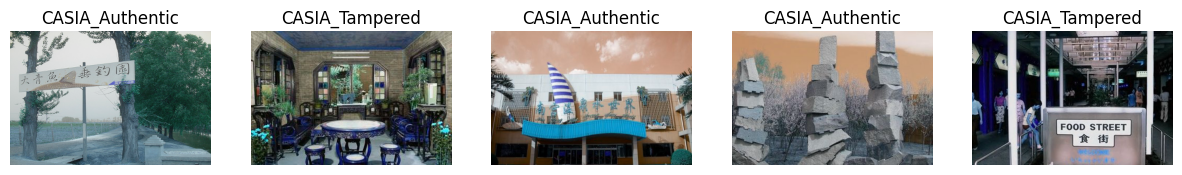

In [ ]:
import random
import matplotlib.pyplot as plt

# define the number of images to display
num_images = 5

# randomly select num_images indices from the dataset
indices = random.sample(range(len(Pre_train_images)), num_images)

# plot the selected images along with their labels
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i, idx in enumerate(indices):
    axes[i].imshow(Pre_train_images[idx])
    axes[i].axis('off')
    if Pre_train_labels[idx] == 1:
        axes[i].set_title("CASIA_Authentic")
    else:
       axes[i].set_title("CASIA_Tampered")

plt.show()

### Preprocesing and feature extraction functions

In [ ]:
def preprocess(img):
    # Convert the image to YCbCr color space
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Extract the Cr channel
    img_y, img_cr, img_cb = cv2.split(img_ycrcb)
    # Convert the channels to floating-point format
    img_y = np.float32(img_y)
    img_cr = np.float32(img_cr)
    img_cb = np.float32(img_cb)
    # Apply non-overlapping 8x8 block-wise DCT to each channel
    img_y_dct = np.zeros_like(img_y)
    img_cr_dct = np.zeros_like(img_cr)
    img_cb_dct = np.zeros_like(img_cb)
    for i in range(0, img_y.shape[0], 8):
        for j in range(0, img_y.shape[1], 8):
            img_y_dct[i:i+8, j:j+8] = cv2.dct(img_y[i:i+8, j:j+8])
            img_cr_dct[i:i+8, j:j+8] = cv2.dct(img_cr[i:i+8, j:j+8])
            img_cb_dct[i:i+8, j:j+8] = cv2.dct(img_cb[i:i+8, j:j+8])
    # Round DCT coefficients to nearest integer values for each channel
    img_y_dct = np.round(img_y_dct)
    img_cr_dct = np.round(img_cr_dct)
    img_cb_dct = np.round(img_cb_dct)
    # Calculate decorrelation features for each channel
    Dhintra_y = img_y_dct[:-1, :] - img_y_dct[1:, :]
    Dvintra_y = img_y_dct[:, :-1] - img_y_dct[:, 1:]
    Dhinter_y = img_y_dct[:-8, :] - img_y_dct[8:, :]
    Dvinter_y = img_y_dct[:, :-8] - img_y_dct[:, 8:]

    Dhintra_cr = img_cr_dct[:-1, :] - img_cr_dct[1:, :]
    Dvintra_cr = img_cr_dct[:, :-1] - img_cr_dct[:, 1:]
    Dhinter_cr = img_cr_dct[:-8, :] - img_cr_dct[8:, :]
    Dvinter_cr = img_cr_dct[:, :-8] - img_cr_dct[:, 8:]

    Dhintra_cb = img_cb_dct[:-1, :] - img_cb_dct[1:, :]
    Dvintra_cb = img_cb_dct[:, :-1] - img_cb_dct[:, 1:]
    Dhinter_cb = img_cb_dct[:-8, :] - img_cb_dct[8:, :]
    Dvinter_cb = img_cb_dct[:, :-8] - img_cb_dct[:, 8:]

    return Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y, Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr, Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb

In [ ]:
#Function to apply the Markov random process
def apply_markov_process(Dh_intra, Dv_intra, Dh_inter, Dv_inter, threshold=8):
    # Resize the matrices to the same size
    min_rows = min(Dh_intra.shape[0], Dv_intra.shape[0], Dh_inter.shape[0], Dv_inter.shape[0])
    min_cols = min(Dh_intra.shape[1], Dv_intra.shape[1], Dh_inter.shape[1], Dv_inter.shape[1])
    Dh_intra = Dh_intra[:min_rows, :min_cols]
    Dv_intra = Dv_intra[:min_rows, :min_cols]
    Dh_inter = Dh_inter[:min_rows, :min_cols]
    Dv_inter = Dv_inter[:min_rows, :min_cols]
    # Apply the Markov random process
    markov_matrix = np.zeros(Dh_intra.shape)
    for i in range(1, Dh_intra.shape[0]):
        for j in range(1, Dh_intra.shape[1]):
            if abs(Dh_intra[i, j]) > threshold or abs(Dv_intra[i, j]) > threshold or abs(Dh_inter[i, j]) > threshold or abs(Dv_inter[i, j]) > threshold:
                markov_matrix[i, j] = 1
    return markov_matrix

In [ ]:
# function to get the decorrelation matrix
def get_decorrelation_matrix(Dh_intra, Dv_intra, Dh_inter, Dv_inter):
     """
     Compute the decorrelation matrix given the four discrete wavelet transform coefficients:
     Dhintra, Dvintra, Dhinter, Dvinter for a particular YCbCr type

     Args:
     Dhintra: array_like, (height, width)
         Coefficients of horizontal high pass subband obtained using intra frame prediction
     Dvintra: array_like, (height, width)
         Coefficients of vertical high pass subband obtained using intra frame prediction
     Dhinter: array_like, (height, width)
         Coefficients of horizontal high pass subband obtained using inter frame prediction
     Dvinter: array_like, (height, width)
         Coefficients of vertical high pass subband obtained using inter frame prediction

     Returns:
     decorrelation_matrix: array_like, (4, 4)
         The decorrelation matrix computed from the given wavelet coefficients
     """
     # Resize the matrices to the same size

     min_rows = min(Dh_intra.shape[0], Dv_intra.shape[0], Dh_inter.shape[0], Dv_inter.shape[0])
     min_cols = min(Dh_intra.shape[1], Dv_intra.shape[1], Dh_inter.shape[1], Dv_inter.shape[1])
     Dh_intra = Dh_intra[:min_rows, :min_cols]
     Dv_intra = Dv_intra[:min_rows, :min_cols]
     Dh_inter = Dh_inter[:min_rows, :min_cols]
     Dv_inter = Dv_inter[:min_rows, :min_cols]
     # Concatenate the four subbands into a single array
     decorrelation_matrix  = np.stack((Dh_intra, Dv_intra, Dh_inter, Dv_inter))

     return decorrelation_matrix

### Splititing the datasets into training and testing for the pretrain process

In [ ]:
# Split the Pre-training dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_pretrain, X_pretest, y_pretrain, y_pretest = train_test_split(Pre_train_images, Pre_train_labels, random_state=42)

In [ ]:
# Preprocess the images
X_pretrain_processed = []
for img in X_pretrain:
    if img is not None and img.size > 0:
        img = img.astype(np.float32) # Convert the image to 32-bit float format
        Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y, Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr, Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb = preprocess(img)
        markov_matrix1 = apply_markov_process(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
        markov_matrix2 = apply_markov_process(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
        markov_matrix3 = apply_markov_process( Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
        feature1 = markov_matrix1.flatten()
        feature2 = markov_matrix2.flatten()
        feature3 = markov_matrix3.flatten()
        features = np.concatenate((feature1, feature2, feature3), axis=0)
        X_pretrain_processed.append(features)
    else:
        print("Invalid image encountered in training set, skipping...")

X_pretest_processed = []
for img in X_pretest:
    if img is not None and img.size > 0:
        img = img.astype(np.float32) # Convert the image to 32-bit float format
        Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y, Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr, Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb = preprocess(img)
        markov_matrix1 = apply_markov_process(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
        markov_matrix2 = apply_markov_process(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
        markov_matrix3 = apply_markov_process( Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
        feature1 = markov_matrix1.flatten()
        feature2 = markov_matrix2.flatten()
        feature3 = markov_matrix3.flatten()
        features = np.concatenate((feature1, feature2, feature3), axis=0)
        X_pretest_processed.append(features)
    else:
        print("Invalid image encountered in test set, skipping...")

### Another method to preprocess the images

In [ ]:
# Preprocess the images and get the feature extraction
X_pretrain_processed = []
for img in X_pretrain:
  if img is not None and img.size > 0:
    Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y, Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr, Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb = preprocess(img)
    markov_matrix1 = apply_markov_process(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
    markov_matrix2 = apply_markov_process(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
    markov_matrix3 = apply_markov_process(Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
    decorrelation_matrix1 = get_decorrelation_matrix(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
    decorrelation_matrix2 = get_decorrelation_matrix(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
    decorrelation_matrix3 = get_decorrelation_matrix(Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
    feature1 = np.concatenate((markov_matrix1.flatten(), decorrelation_matrix1.flatten()))
    feature2 = np.concatenate((markov_matrix2.flatten(), decorrelation_matrix2.flatten()))
    feature3 = np.concatenate((markov_matrix3.flatten(), decorrelation_matrix3.flatten()))
    features = np.concatenate((feature1, feature2, feature3), axis=0)
    X_pretrain_processed.append(features)
  else:
    print("Invalid image encountered in training set, skipping...")

X_pretest_processed = []
for img in X_pretest:
  if img is not None and img.size > 0:
    Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y, Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr, Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb = preprocess(img)
    markov_matrix1 = apply_markov_process(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
    markov_matrix2 = apply_markov_process(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
    markov_matrix3 = apply_markov_process(Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
    decorrelation_matrix1 = get_decorrelation_matrix(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
    decorrelation_matrix2 = get_decorrelation_matrix(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
    decorrelation_matrix3 = get_decorrelation_matrix(Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
    feature1 = np.concatenate((markov_matrix1.flatten(), decorrelation_matrix1.flatten()))
    feature2 = np.concatenate((markov_matrix2.flatten(), decorrelation_matrix2.flatten()))
    feature3 = np.concatenate((markov_matrix3.flatten(), decorrelation_matrix3.flatten()))
    features = np.concatenate((feature1, feature2, feature3), axis=0)
    X_pretest_processed.append(features)
  else:
    print("Invalid image encountered in test set, skipping...")


In [ ]:
### Convert the preprocessed images to NumPy arrays
X_pretrain_processed = np.array(X_pretrain_processed,dtype=object)
X_pretest_processed = np.array(X_pretest_processed,dtype=object)

In [ ]:
X_pretrain_processed.shape

(75, 279744)

### Training algorthimm

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix

# Create an SVM classifier with a linear kernel
clf = svm.SVC(kernel='linear')

# Train the SVM classifier on the training data
clf.fit(X_pretrain_processed, y_pretrain)

# Use the trained SVM classifier to predict labels for the train and test data
y_train_pred = clf.predict(X_pretrain_processed)
y_test_pred = clf.predict(X_pretest_processed)

# Evaluate the accuracy of the SVM classifier on train and test data
train_accuracy = clf.score(X_pretrain_processed, y_pretrain) * 100
test_accuracy = accuracy_score(y_pretest, y_test_pred) * 100

# Calculate the confusion matrix for the test data
tn, fp, fn, tp = confusion_matrix(y_pretest, y_test_pred).ravel()

# Calculate the true positive rate, true negative rate, false positive rate, and false negative rate
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("Train Accuracy: {:.2f}%".format(train_accuracy))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("True Positive Rate: {:.2f}%".format(tpr*100))
print("True Negative Rate: {:.2f}%".format(tnr*100))
print("False Positive Rate: {:.2f}%".format(fpr*100))
print("False Negative Rate: {:.2f}%".format(fnr*100))

Train Accuracy: 100.00%
Test Accuracy: 76.00%
True Positive Rate: 85.71%
True Negative Rate: 63.64%
False Positive Rate: 36.36%
False Negative Rate: 14.29%


In [ ]:
import joblib
# Save the trained model to a file
filename = 'ML_svm_model.joblib'
joblib.dump(clf, filename)

['ML_svm_model.joblib']

### training the same model on the Traindev dataset

In [ ]:
## Load the Traindev dataset
data_dir = '/content/drive/MyDrive/Image_detection_system/Data/train_Svm'
train_images = []
train_labels = []
num_authentic = 50  # define the desired number of authentic images
num_tampered = 50  # define the desired number of tampered images
count_authentic = 0  # initialize a counter variable for authentic images
count_tampered = 0  # initialize a counter variable for tampered images

for subdir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, subdir)
    print(sub_dir_path)
    if os.path.isdir(sub_dir_path):
        for file in os.listdir(sub_dir_path):
            if file.endswith('.jpg'):
                image_path = os.path.join(sub_dir_path, file)
                #print(image_path)
                image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                dim = (384, 256)
                resized = cv2.resize(image, dim, interpolation = cv2.INTER_LANCZOS4)  # resize image
                if 'authentic' in subdir and count_authentic < num_authentic:
                  train_images.append(resized)
                  train_labels.append(1)  # authentic image
                  count_authentic += 1 # increment the counter variable for authentic
                elif 'Tampered' in subdir and count_tampered < num_tampered:
                    train_images.append(resized)
                    train_labels.append(0)  # tampered image
                    count_tampered += 1  # increment the counter variable for tampered images
                if count_authentic == num_authentic and count_tampered == num_tampered:
                    break  # break the loop if the desired number of authentic and tampered images have been loaded
        if count_authentic == num_authentic and count_tampered == num_tampered:
            break


/content/drive/MyDrive/Image_detection_system/Data/train_Svm/Tampered
/content/drive/MyDrive/Image_detection_system/Data/train_Svm/authentic


In [ ]:
train_images

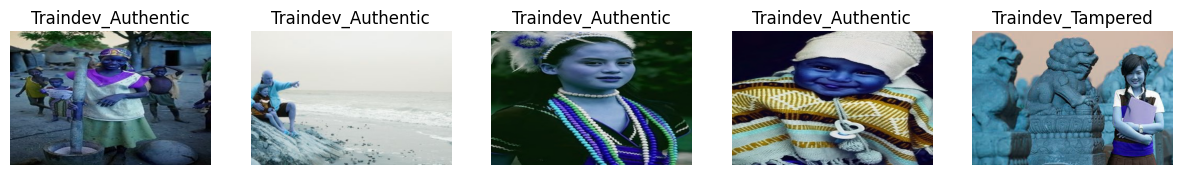

In [ ]:
# define the number of images to display
num_images = 5

# randomly select num_images indices from the dataset
indices = random.sample(range(len(train_images)), num_images)

# plot the selected images along with their labels
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i, idx in enumerate(indices):
    axes[i].imshow(train_images[idx])
    axes[i].axis('off')
    if train_labels[idx] == 1:
        axes[i].set_title("Traindev_Authentic")
    else:
       axes[i].set_title("Traindev_Tampered")

plt.show()

In [ ]:
# Split the training dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, random_state=42)

In [ ]:
# Preprocess the training images and get the feature extraction
X_train_processed = []
for img in X_train:
    if img is not None and img.size > 0:
        img = img.astype(np.float32) # Convert the image to 32-bit float format
        Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y, Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr, Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb = preprocess(img)
        markov_matrix1 = apply_markov_process(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
        markov_matrix2 = apply_markov_process(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
        markov_matrix3 = apply_markov_process( Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
        feature1 = markov_matrix1.flatten()
        feature2 = markov_matrix2.flatten()
        feature3 = markov_matrix3.flatten()
        features = np.concatenate((feature1, feature2, feature3), axis=0)
        X_train_processed.append(features)
    else:
        print("Invalid image encountered in training set, skipping...")

X_test_processed = []
for img in X_test:
    if img is not None and img.size > 0:
        img = img.astype(np.float32) # Convert the image to 32-bit float format
        Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y, Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr, Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb = preprocess(img)
        markov_matrix1 = apply_markov_process(Dhintra_y, Dvintra_y, Dhinter_y, Dvinter_y)
        markov_matrix2 = apply_markov_process(Dhintra_cr, Dvintra_cr, Dhinter_cr, Dvinter_cr)
        markov_matrix3 = apply_markov_process( Dhintra_cb, Dvintra_cb, Dhinter_cb, Dvinter_cb)
        feature1 = markov_matrix1.flatten()
        feature2 = markov_matrix2.flatten()
        feature3 = markov_matrix3.flatten()
        features = np.concatenate((feature1, feature2, feature3), axis=0)
        X_test_processed.append(features)
    else:
        print("Invalid image encountered in test set, skipping...")


In [ ]:
### Convert the preprocessed images to NumPy arrays
X_train_processed_reshaped = np.array(X_train_processed, dtype=object)
X_test_processed_reshaped = np.array(X_test_processed, dtype=object)

In [ ]:
X_train_processed_reshaped.shape

(75, 279744)

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the saved model from a file
file_dir = '/content/drive/MyDrive/Image_detection_system/Environments/ML_svm_model.joblib'
loaded_model = joblib.load(file_dir)

# Train the loaded SVM classifier on the training data
loaded_model.fit(X_train_processed_reshaped, y_train)

# Use the trained SVM classifier to predict labels for the train and test data
y_train_pred = loaded_model.predict(X_train_processed_reshaped)
y_test_pred = loaded_model.predict(X_test_processed_reshaped)

# Evaluate the accuracy of the SVM classifier on train and test data
train_accuracy = loaded_model.score(X_train_processed_reshaped, y_train) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

# Calculate the confusion matrix for the test data
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Calculate the true positive rate, true negative rate, false positive rate, and false negative rate
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("Train Accuracy: {:.2f}%".format(train_accuracy))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("True Positive Rate: {:.2f}%".format(tpr*100))
print("True Negative Rate: {:.2f}%".format(tnr*100))
print("False Positive Rate: {:.2f}%".format(fpr*100))

Train Accuracy: 100.00%
Test Accuracy: 72.00%
True Positive Rate: 63.64%
True Negative Rate: 78.57%
False Positive Rate: 21.43%


In [ ]:
import joblib
# Save the trained model to a file
filename = 'ML_svm_model_traindev.joblib'
joblib.dump(loaded_model, filename)

['ML_svm_model_traindev.joblib']

### Training for the classifiaction of Spliced and copy moved forged

In [ ]:
# Load the spliced and copy moved train dataset
train_data_dir = '/content/drive/MyDrive/Image_detection_system/Data/traindev'
class_images = []
class_labels = []
num_authentic = 100  # define the desired number of authentic images
num_tampered = 100  # define the desired number of tampered images
count_tampered = 0  # initialize a counter variable for tampered images

for subdir in os.listdir(train_data_dir):
    train_sub_dir_path = os.path.join(train_data_dir, subdir)
    #print(train_sub_dir_path)
    for ssubdir in os.listdir(train_sub_dir_path):
      forged_path = os.path.join(train_data_dir, subdir, ssubdir)
      #print(forged_path)
      if os.path.isdir(forged_path):
        for file in os.listdir(forged_path):
          if file.endswith('.jpg'):
            if 'c_' in file:
              tamp_image_path = os.path.join(forged_path, file)
              print(tamp_image_path)
              tamp_image = cv2.imread(tamp_image_path,cv2.IMREAD_UNCHANGED)
              dim = (384, 256)
              tamp_image_resized = cv2.resize(tamp_image, dim, interpolation = cv2.INTER_LANCZOS4)  # resize image
              class_images.append(tamp_image_resized)
              class_labels.append(1) # Copy-moved image
              count_tampered += 1  # increment the counter variable for tampered image
            if 's_' in file:
              spliced_image_path = os.path.join(forged_path, file)
              print(spliced_image_path)
              spliced_image = cv2.imread(spliced_image_path,cv2.IMREAD_UNCHANGED)
              dim = (384, 256)
              spliced_image_resized = cv2.resize(spliced_image, dim, interpolation = cv2.INTER_LANCZOS4)  # resize image
              class_images.append(spliced_image_resized)
              class_labels.append(0) # spliced image
              count_tampered += 1

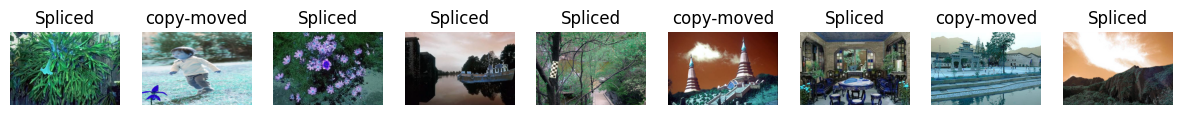

In [ ]:
import random
import matplotlib.pyplot as plt

# define the number of images to display
num_images = 9

# randomly select num_images indices from the dataset
indices = random.sample(range(len(class_images)), num_images)

# plot the selected images along with their labels
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i, idx in enumerate(indices):
    axes[i].imshow(class_images[idx])
    axes[i].axis('off')
    if class_labels[idx] == 2:
        axes[i].set_title("Authentic")
    elif class_labels[idx] == 1:
       axes[i].set_title("copy-moved")
    if class_labels[idx] == 0:
        axes[i].set_title("Spliced")

plt.show()

In [ ]:
# Split the dataset into training and testing sets
num_samples = len(class_images)
indices = np.random.permutation(num_samples)
split = int(0.8 * num_samples)  # 80% training, 20% testing
class_train_indices, class_test_indices = indices[:split], indices[split:]
class_train_images = [class_images[i] for i in class_train_indices]
class_train_labels = [class_labels[i] for i in class_train_indices]
class_test_images = [class_images[i] for i in class_test_indices]
class_test_labels = [class_labels[i] for i in class_test_indices]

### Function for feature extraction of images

In [ ]:
# Extract features using texture descriptors (e.g. LBP) and color histograms
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

def extract_features(image):
    gray = rgb2gray(image)
    lbp = local_binary_pattern(gray, 8, 1)
    hist, _ = np.histogram(lbp.ravel(), bins=256)
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    features = np.concatenate((hist, color_hist.flatten()))
    return features

In [ ]:
train_features = [extract_features(image) for image in class_train_images]
test_features = [extract_features(image) for image in class_test_images]

In [ ]:
# Train an SVM classifier on the training set
from sklearn import svm
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(train_features, class_train_labels)

SVC(kernel='linear')

### Predicting classses from the images using the linear SVM model

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Predict the labels of the training set
train_predictions = svm_classifier.predict(train_features)

# Evaluate the performance of the SVM classifier with rbf kernal on the training set
train_accuracy = np.mean(train_predictions == class_train_labels)* 100
print(f'Train Accuracy: {train_accuracy:.3f}')

# Evaluate the performance on the testing set
test_predictions = svm_classifier.predict(test_features)
test_accuracy = np.mean(test_predictions == class_test_labels)* 100
print(f'Test Accuracy: {test_accuracy:.3f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(class_test_labels, test_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

# Calculate the true positive rate, true negative rate, false positive rate, and false negative rate
tn, fp, fn, tp = confusion_matrix(class_test_labels, test_predictions).ravel()

tpr = tp / (tp + fn)* 100
tnr = tn / (tn + fp)* 100
fpr = fp / (tn + fp)* 100
fnr = fn / (tp + fn)* 100

print(f'True Positive Rate: {tpr:.3f}')
print(f'True Negative Rate: {tnr:.3f}')
print(f'False Positive Rate: {fpr:.3f}')
print(f'False Negative Rate: {fnr:.3f}')
print(classification_report(class_test_labels,test_predictions)) # print the classification report

Train Accuracy: 83.349
Test Accuracy: 66.415
Confusion Matrix:
[[139  39]
 [ 50  37]]
True Positive Rate: 42.529
True Negative Rate: 78.090
False Positive Rate: 21.910
False Negative Rate: 57.471
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       178
           1       0.49      0.43      0.45        87

    accuracy                           0.66       265
   macro avg       0.61      0.60      0.61       265
weighted avg       0.65      0.66      0.66       265



### Find the best model by GRIDsearchCV to find the best hyperparameters for the model and dataset

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(train_features,class_train_labels)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(test_features)

# print classification report
print(classification_report(class_test_labels, grid_predictions))


### Save the model

In [ ]:
import joblib
joblib.dump(svm_classifier, 'svm_model_traindev.pkl')

['svm_model_traindev.pkl']